<a href="https://colab.research.google.com/github/PoojaReddyNamireddy/cs480student/blob/main/CS480_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

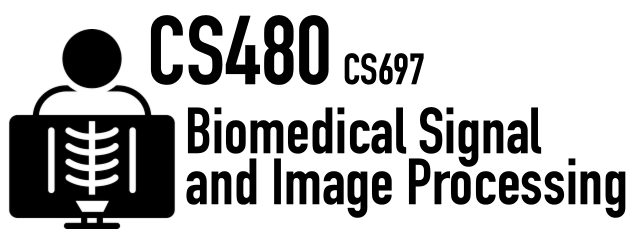
#Assignment 5

In [ ]:
# In this assignment, we will visualize and explore a CT scan!

In [ ]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# we are using pydicom, so lets install it!
!pip install pydicom

**Task 1**: Download and visualize data with SliceDrop! [20 Points]

In [ ]:
# Please download https://cs480.org/data/ct.zip and extract it on your computer!
# This is a CT scan of an arm in DICOM format.

In [ ]:
# 1) Let's explore the data without loading it.
# TODO: Without loading the data, how many slices are there?

There are 220 images in the zip file. Hence it has 220 slices

In [ ]:
# TODO: YOUR_ANSWER

In [ ]:
# 2) Let's visualize the data with SliceDrop! 
# Go to https://slicedrop.com and drag'n'drop all .dcm files into the browser.
# Please use the 2D sliders to show axial, sagittal, and coronal slices in 3D.

In [ ]:
# TODO Please post a screenshot of SliceDrop's 3D View in the text box below by 
# using the Upload image button after double-click.

Coronal View

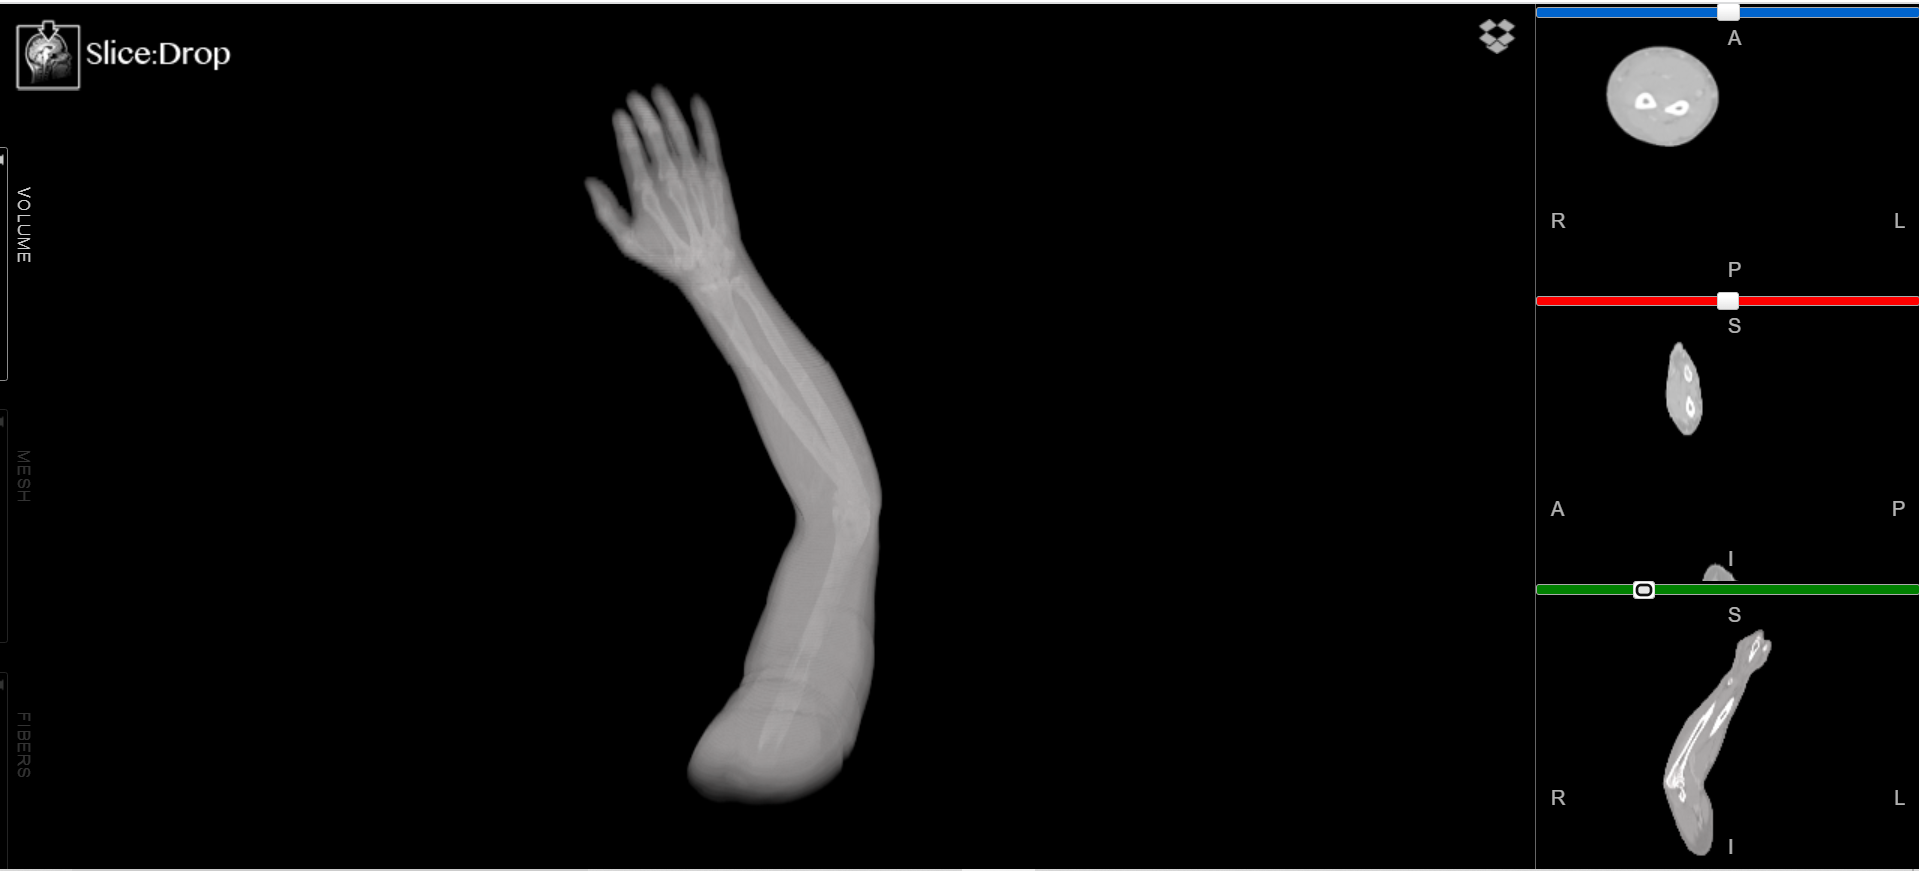

Sagittal View

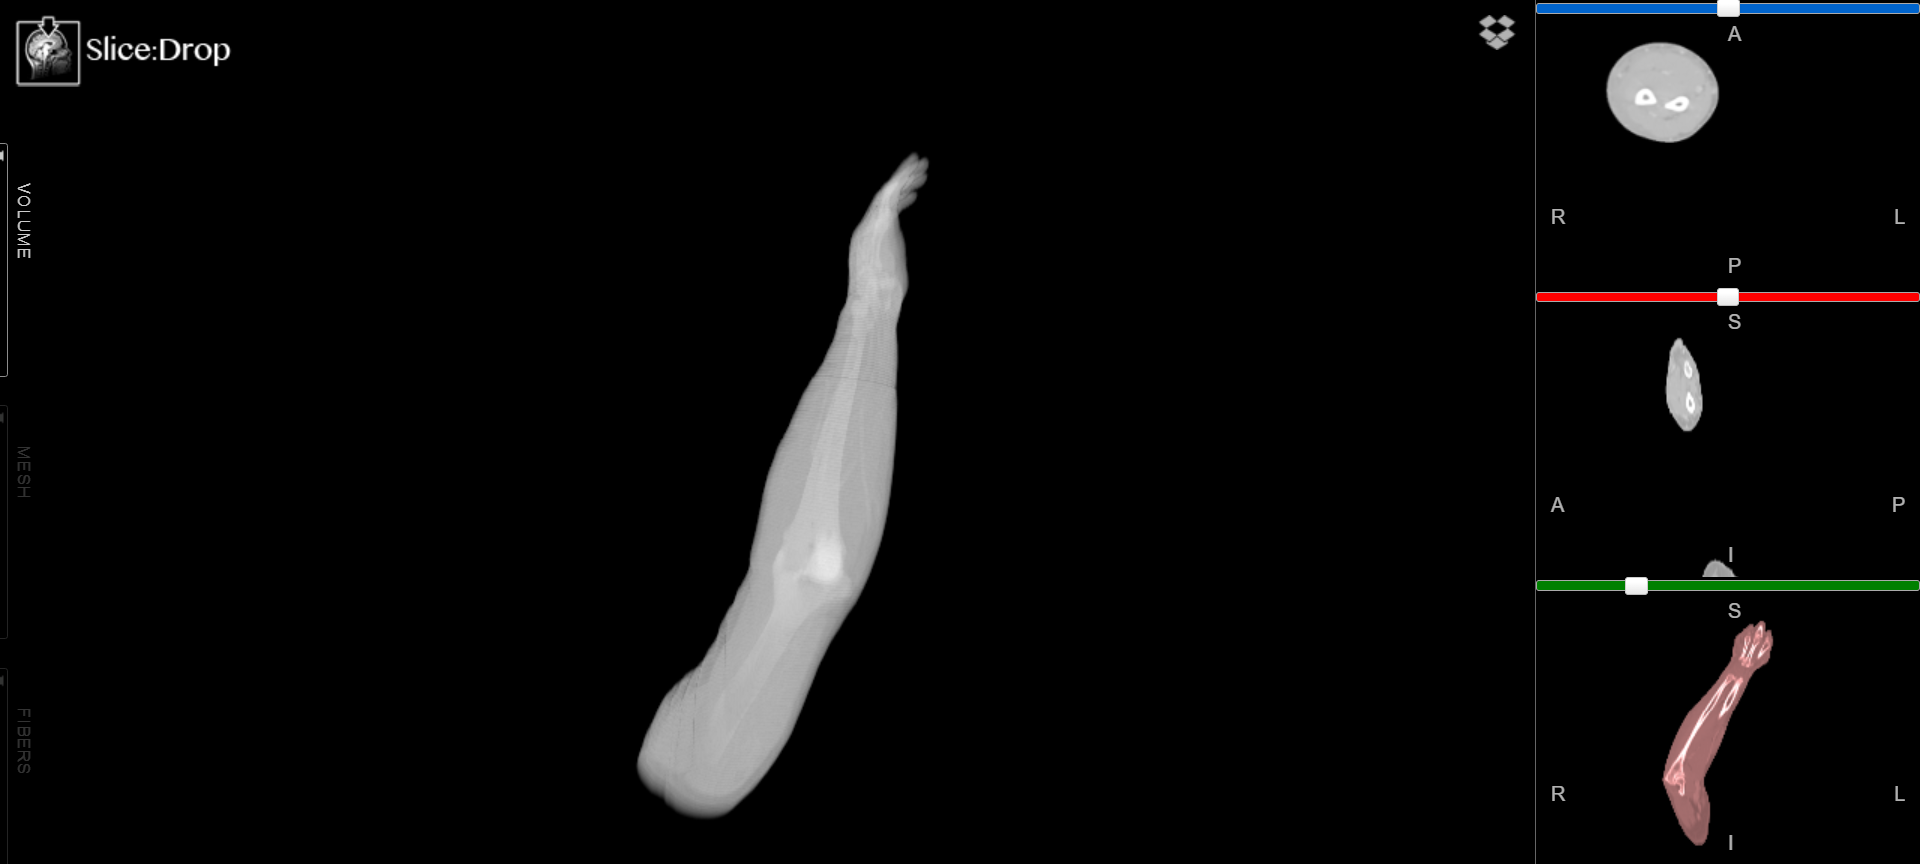

Axial View

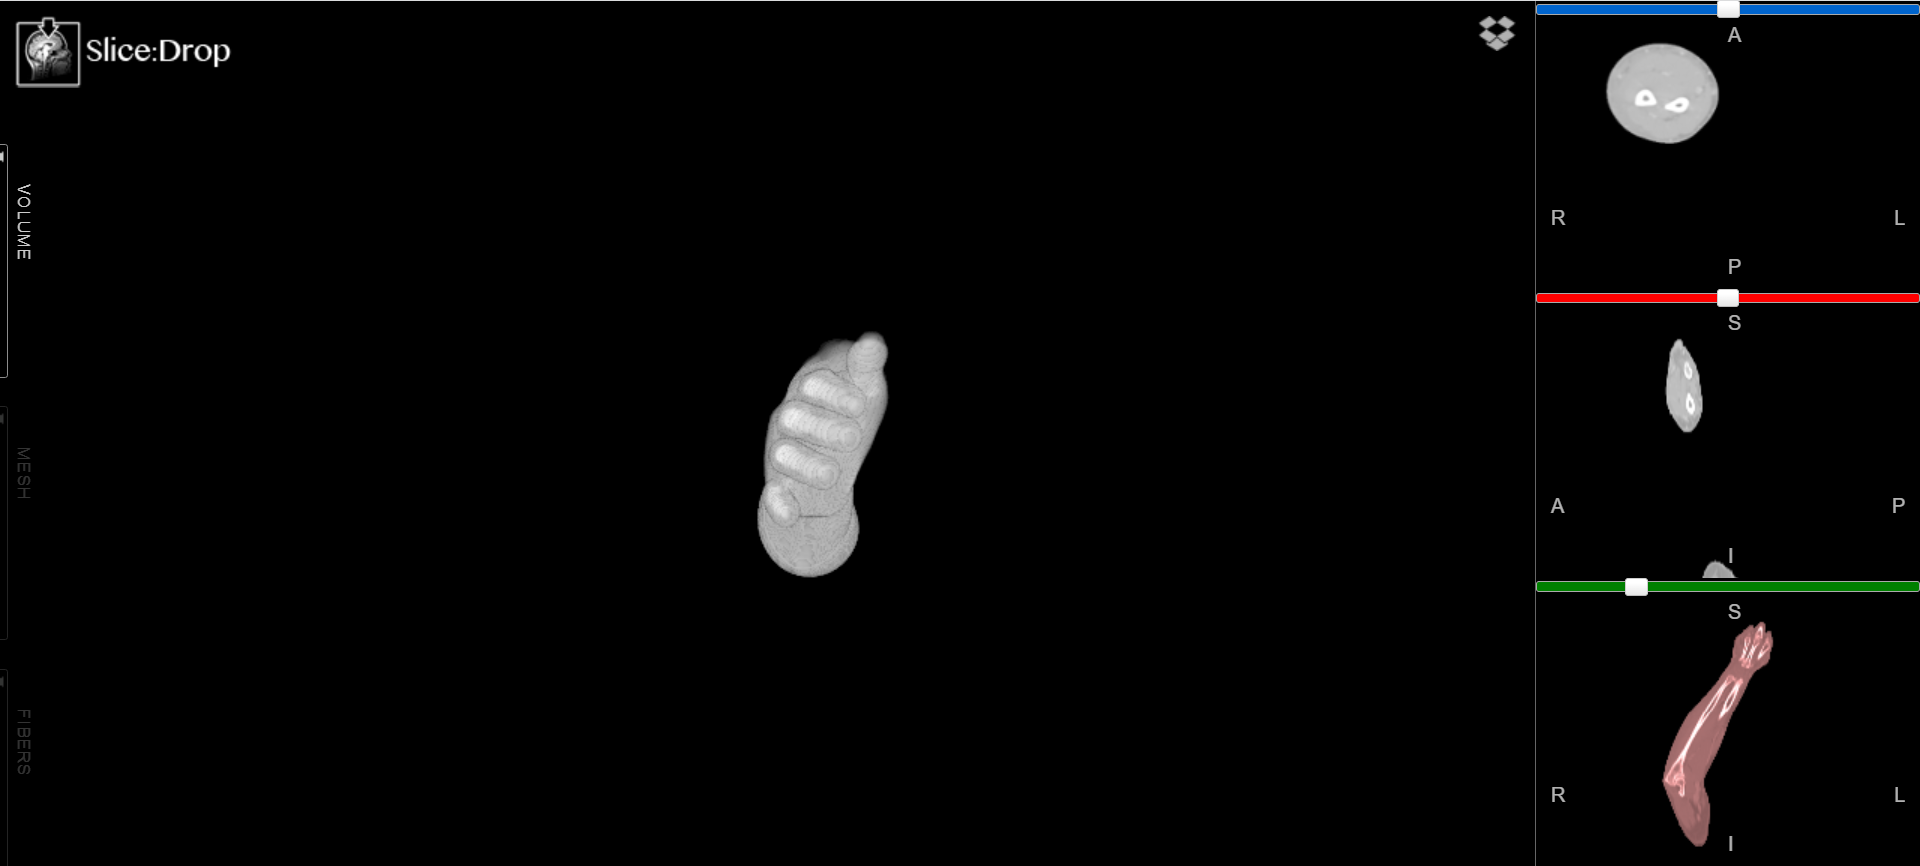

**Task 2**: Load the data using pydicom as a 3D volume and then reslice it! [35 Points]

In [ ]:
# TODO: Please upload ct.zip using the file panel on the left.
# Then use the following snippet to extract the data.

In [ ]:
import zipfile
with zipfile.ZipFile('ct.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
# 1) Now loop through all the DICOM files and store them in a 3D numpy array.
# Hint: You can either store them in a list first or read the dimensions of a
# single image slice to properly create the 3D numpy array.
# Hint 2: os.listdir(DIR) gives a list of filenames in a directory.
# Hint 2b: This list is not sorted - make sure you sort it.
# Hint 3: The dcmread function loads a single DICOM file.
# Hint 4: You can then use .pixel_array to access the image data.

In [ ]:
pip install pydicom

In [ ]:
from pydicom import dcmread
import os

In [ ]:
# TODO: YOUR CODE FOR LOADING THE VOLUME AS A 3D NUMPY ARRAY

In [ ]:
files = sorted(os.listdir('ct'))

In [ ]:
slice0 = dcmread('ct/'+files[0])
slice0_shape = [i for i in slice0.pixel_array.shape]
slice0_shape.append(len(files))

In [ ]:
images = np.zeros(slice0_shape, dtype=float)

In [ ]:
for k in range(0, len(files)):
  slice_array = dcmread('ct/'+files[k]).pixel_array
  images[:,:,k] = slice_array

In [ ]:
# 2) Now create and show axial, sagittal, and coronal slices from the 3D volume.
# Hint: Please use imshow(XX, cmap='gray') to show the image.

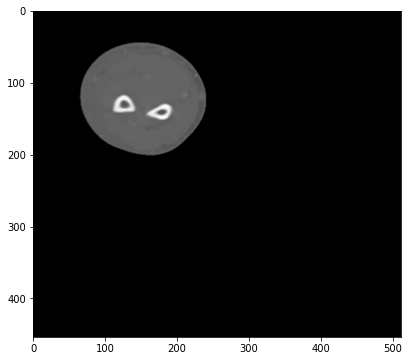

In [ ]:
# TODO: YOUR CODE FOR AXIAL
plt.figure(figsize = (8,6))
plt.imshow(images[:,:,slice0_shape[2]//2], cmap='gray')

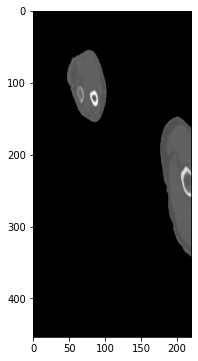

In [ ]:
# TODO: YOUR CODE FOR SAGITTAL
plt.figure(figsize = (8,6))
plt.imshow(images[:,slice0_shape[1]//2], cmap='gray')

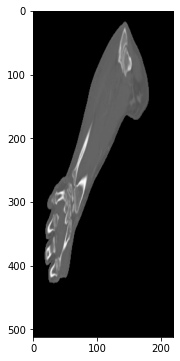

In [ ]:
# TODO: YOUR CODE FOR CORONAL
plt.figure(figsize = (8,6))
plt.imshow(images[slice0_shape[2]//2], cmap='gray')

**Task 3**: Use the Window/Level-technique to visualize the data! [45 Points]

In [ ]:
# We will now enhance the visualization from above by performing 
# Window/Level adjustment.
# Here is one way of doing that:
#   vmin = level - window/2
#   vmax = level + window/2
#   plt.imshow(hu_pixels + rescale, cmap='gray', vmin=vmin, vmax=vmax)
#   plt.show()

In [ ]:
# 1) Please load the Window/Level values from the DICOM file,
# print these values, and then visualize one slice with window/level adjustment.
# Hint: The DICOM header has the following tags.
#   (0028, 1050) Window Center 
#   (0028, 1051) Window Width
# Hint 2: You can use slice[key].value to access DICOM tag values.
# Hint 3: (0028, 1052) Rescale Intercept might be important.

In [ ]:
# TODO: YOUR CODE

slices = dcmread('ct/'+files[200])

In [ ]:
lvl = slices['WindowCenter'].value
window = slices['WindowWidth'].value
rescale = slices['RescaleIntercept'].value
print(slices[0x0028, 0x1050])
print(slices[0x0028, 0x1051])


(0028, 1050) Window Center                       DS: '30.0'
(0028, 1051) Window Width                        DS: '410.0'


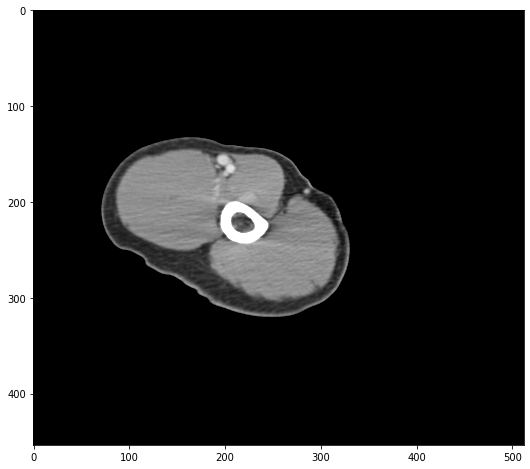

In [ ]:
vmin = lvl - window/2
vmax = lvl + window/2

plt.figure(figsize=(10,8))
hu_pixels = slices.pixel_array
plt.imshow(hu_pixels+rescale, cmap='gray', vmin = vmin, vmax = vmax)
plt.show()

In [ ]:
# 2) Play around with different Window/Level values that enhance
# the visualization.

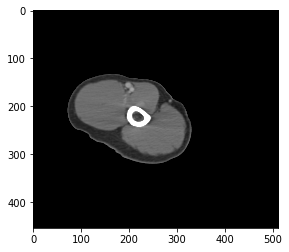

In [ ]:
# TODO: YOUR CODE

lvl = 100
window = 600
vmin = lvl - window/2
vmax = lvl + window/2

plt.imshow(hu_pixels+rescale, cmap='gray', vmin = vmin, vmax = vmax)

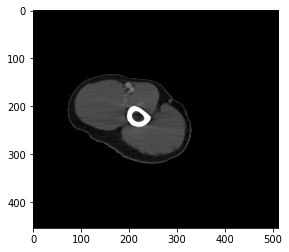

In [ ]:
lvl = 200
window = 700
vmin = lvl - window/2
vmax = lvl + window/2

plt.imshow(hu_pixels+rescale, cmap='gray', vmin = vmin, vmax = vmax)

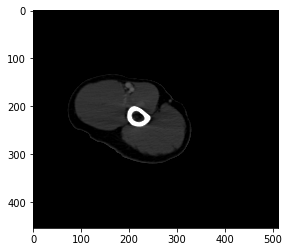

In [ ]:
lvl = 300
window = 800
vmin = lvl - window/2
vmax = lvl + window/2

plt.imshow(hu_pixels+rescale, cmap='gray', vmin = vmin, vmax = vmax)

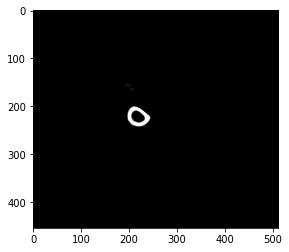

In [ ]:
lvl = 600
window = 1000
vmin = lvl - window/2
vmax = lvl + window/2

plt.imshow(hu_pixels+rescale, cmap='gray', vmin = vmin, vmax = vmax)

In [ ]:
# Which values make sense and why?

In [ ]:
# TODO: YOUR ANSWER

**As the increase in the window value the bone seems more clearer. Hence I can conclude that the last values i.e level = 600 and window = 1000 makes some sense**

**Bonus**: Create segmentations (label maps) for the volume using thresholding HU! [33 Points]

In [ ]:
# Similar to Window/Level adjustment for visualization, we can threshold
# the volume to highlight the following components using the Hounsfield Units:
# 1) Fat
# 2) Soft Tissue
# 3) Bones
#
# Please create 3 segmentation masks for these structures.
# Then, please visualize each 3 slices per structure to showcase the segmentation.
# Hint: As a reminder, the following code allows thresholding of a numpy array.
#   new_mask = imagevolume.copy()
#   new_mask[new_mask < XXX] = 0
# Hint2: You might need to cast new_mask to int16 not uint16.

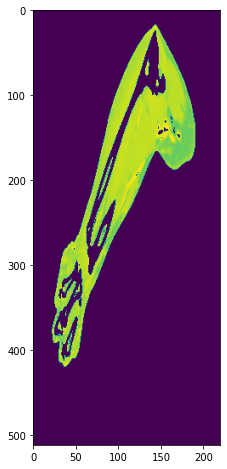

In [ ]:
# TODO: YOUR CODE TO SEGMENT FAT
plt.figure(figsize = (10,8))
mask = images[120].copy()
mask = mask.astype(np.int16)
mask[mask>1200] = 0
mask[mask<900] = 0
plt.imshow(mask,)

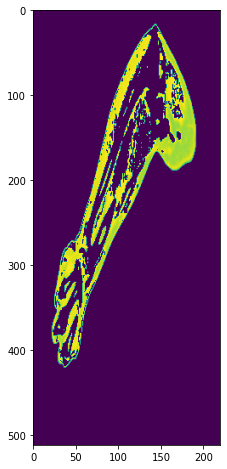

In [ ]:
# TODO: YOUR CODE TO SEGMENT SOFT TISSUE

plt.figure(figsize = (10,8))
mask2 = images[120].copy()
mask2 = mask2.astype(np.int16)
mask2[mask2>1080] = 0
plt.imshow(mask2,)

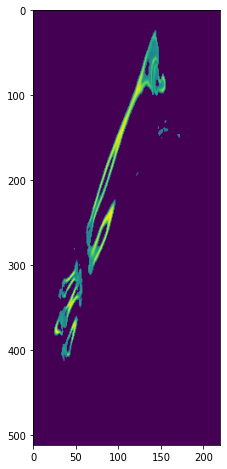

In [ ]:
# TODO: YOUR CODE TO SEGMENT BONES
plt.figure(figsize = (10,8))
mask3 = images[120].copy()
mask3 = mask3.astype(np.int16)
mask3[mask3<1200] = 0
plt.imshow(mask3,)


In [ ]:
# Are the segmentations good?

In [ ]:
# TODO: YOUR ANSWER

**All the segmentations that are obtained are pretty much decent and satisfactory**

In [ ]:
#
# Thank you and Great job!!
#
#                _.---._
#              .'       `.
#              :)       (:
#              \ (@) (@) /
#               \   A   /
#                )     (
#                \"""""/
#                 `._.'
#                  .=.
#          .---._.-.=.-._.---.
#         / ':-(_.-: :-._)-:` \
#        / /' (__.-: :-.__) `\ \
#       / /  (___.-` '-.___)  \ \
#      / /   (___.-'^`-.___)   \ \
#     / /    (___.-'=`-.___)    \ \
#    / /     (____.'=`.____)     \ \
#   / /       (___.'=`.___)       \ \
#  (_.;       `---'.=.`---'       ;._)
#  ;||        __  _.=._  __        ||;
#  ;||       (  `.-.=.-.'  )       ||;
#  ;||       \    `.=.'    /       ||;
#  ;||        \    .=.    /        ||;
#  ;||       .-`.`-._.-'.'-.       ||;
# .:::\      ( ,): O O :(, )      /:::.
# |||| `     / /'`--'--'`\ \     ' ||||
# ''''      / /           \ \      ''''
#          / /             \ \
#         / /               \ \
#        / /                 \ \
#       / /                   \ \
#      / /                     \ \
#     /.'                       `.\
#    (_)'                       `(_)
#     \\.                       .//
#      \\.                     .//
#       \\.                   .//
#        \\.                 .//
#         \\.               .//
#          \\.             .//
#     jgs   \\.           .//
#           ///)         (\\\
#         ,///'           `\\\,
#        ///'               `\\\
#       ""'                   '""

collab with praveen ganni